# Team work: Handling of available data

For testing your hypothesis in the team work part of the course, different datasets are provided:

- [EODC STAC Catalog](https://services.eodc.eu/browser/#/v1/): Sentinel-1 and other datasets
- Data on JupyterHub:
    - Data used within the hands-on exercise (`~/shared/datasets/rs`): ALOS, ASCAT, soil moisture, ...
    - Austrian Datacube (`~/shared/datasets/fe/data`): Sentinel-1, Sentinel-2, Corine Land Cover, ...
- Additionally, you can bring in your own datasets or access other STAC catalogs.

In this notebook, examples are given how to access the different data sources through the JupyterHub. All shown methods aim to load a `xarray` object, which allows to use many predefined functions and offers a detailed [documentdation](https://docs.xarray.dev/). Besides that you can also work in QGIS, run local Python environments on you own PC or pick tools you are used to. Please be aware that your work needs to end up in a report and presentation at the end!

## STAC data access

Here, a quick recap of [Unit 1]() of the course on how to access data available through STAC. For more details re-visit the corresponding notebook!

In [1]:
import gc

import hvplot.xarray
import matplotlib.pyplot as plt
import pyproj
import pystac_client
from odc import stac as odc_stac

EODC offers a lot of datasets through STAC, but be aware that not all might be accessible. To get an overview, have a look at the collections:

In [2]:
# collections provided by the EODC STAC Catalog
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")
collections = eodc_catalog.get_collections()

max_length = max(len(collection.id) for collection in collections)
for collection in eodc_catalog.get_collections():
    print(f"{collection.id.ljust(max_length)}: {collection.title}")

SENTINEL2_L2A                    : Sentinel-2 MSI Products: Level-2A data
SENTINEL2_GRI_L1C                : Multi-Layer Copernicus Sentinel-2 GRI in L1C
DOP_AUT_K_OSTTIROL               : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Osttirol
SENTINEL1_HPAR                   : SENTINEL1 Harmonic Parameters
AUT_DEM                          : Austrian High Resolution DEM
COP_DEM                          : Copernicus Digital Elevation Model (DEM)
DOP_AUT_K_KLAGENFURT             : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Klagenfurt
DOP_AUT_K_WOLFSBERG              : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Wolfsberg
SENTINEL1_MPLIA                  : SENTINEL1 Mean PLIA
SENTINEL1_SLC                    : Sentinel-1 SLC
SENTINEL1_GRD                    : Sentinel-1 SAR L1 GRD
AI4SAR_SIG0                      : AI4SAR Despeckled Sentinel-1 Sigma0 (20m)
SENTINEL3_SRAL_L2                : Sentinel-3 Products

We will now load Sentinel-1 data for the area of Innsbruck from STAC.

In [3]:
time_range = "2022-03-01/2022-03-31"
innsbruck_bbox = [11.070099, 47.148400, 11.729279, 47.380219]

In [4]:
s1_collection_id = "SENTINEL1_SIG0_20M"
search = eodc_catalog.search(
    collections=s1_collection_id, bbox=innsbruck_bbox, datetime=time_range
)
s1_items = search.item_collection()
len(s1_items)

57

In [5]:
bands = "VV"
chunks = {"time": 1, "latitude": 500, "longitude": 500}

sig0_dc = odc_stac.load(
    s1_items,
    bands=bands,
    crs="EPSG:27704",
    resolution=20,
    bbox=innsbruck_bbox,
    chunks=chunks,
    resampling="bilinear",
)

scale = s1_items[0].assets["VV"].extra_fields.get("raster:bands")[0]["scale"]
nodata = s1_items[0].assets["VV"].extra_fields.get("raster:bands")[0]["nodata"]
sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale
sig0_dc = sig0_dc.dropna(dim="time")
sig0_dc.VV

<xarray.DataArray 'VV' (time: 2, y: 1702, x: 2678)> Size: 36MB
dask.array<getitem, shape=(2, 1702, 2678), dtype=float32, chunksize=(1, 1702, 2678), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 14kB 1.582e+06 1.582e+06 ... 1.548e+06 1.548e+06
  * x            (x) float64 21kB 4.86e+06 4.86e+06 ... 4.913e+06 4.913e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 16B 2022-03-09T05:26:56 2022-03-21T05:...

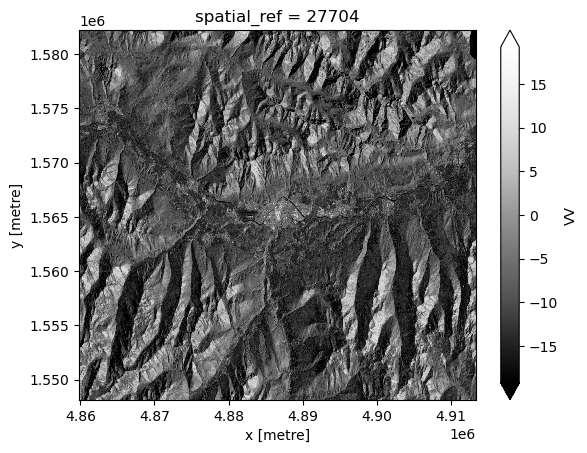

In [6]:
sig0_mean = sig0_dc.mean(dim="time", skipna=True)
sig0_mean.VV.plot(robust=True, cmap="Greys_r")

In [7]:
del sig0_dc
gc.collect()

45

## Data on JupyterHub

Besides the data you saw in the hand-on exercises, the Austrian Datacube (=ACube) is available through the JupyterHub. You can find the data under: `/shared/datasets/fe/data`

Currently, there are 3 types of datasets available:

- Sentinel-1 data
- Sentinel-2 data
- Auxiliary data

### Data structure

The data is projected and tiled based on the Equi7Grid. Therefore, all datasets follow the same folder structure:

PRODUCT / SUBGRID / TILE / LAYER

In [8]:
from pathlib import Path

import hvplot.xarray
import pandas as pd
import rioxarray
import xarray as xr

Consequently, we can define our input paths like this:

In [9]:
source_path = Path(
    r"~/shared/datasets/fe/data"
).expanduser()  # additional data for team part

res = 10  # 10m or 500m
sentinel1_parameter_path = (
    source_path / "sentinel1" / "parameters" / ("EU{}M".format(str(res).zfill(3)))
)
sentinel1_preprocessed_path = (
    source_path / "sentinel1" / "preprocessed" / ("EU{}M".format(str(res).zfill(3)))
)
sentinel2_path = source_path / "sentinel2" / "L2A" / "EU010M"

sentinel1_parameter_path

PosixPath('/home/froth/shared/datasets/fe/data/sentinel1/parameters/EU010M')

### Load data
Once the input paths are defined, one can collect the required data. In the following examples, you can see how single or multiple files can be loaded as xarray object.

#### Sentinel-1 (single file)
How to load a single Sentinel-1 observation file:
- Collect file from file system
- Load it as `xarray.DataSet`
- Prepare the data for further usage (decoding and clean-up)
- Work with the data

In [10]:
def acube_s1_preprocess(x):
    """
    Decode and clean up Sentinel-1 ACube data.

    Parameters
    ----------
    x : xarray.Dataset

    Returns
    -------
    xarray.Dataset
    """

    path = Path(x.encoding["source"])
    filename = path.name

    date_str = filename.split("_")[0][1:]
    time_str = filename.split("_")[1][:6]
    datetime_str = date_str + time_str
    date = pd.to_datetime(datetime_str, format="%Y%m%d%H%M%S")
    x = x.expand_dims(dim={"time": [date]})

    x = (
        x.rename({"band_data": "s1_" + path.parent.stem})
        .squeeze("band")
        .drop_vars("band")
    )

    return x * 0.01

In [11]:
single_path = (
    sentinel1_preprocessed_path
    / "E051N015T1"
    / "sig0"
    / "D20210122_165830--_SIG0-----_S1BIWGRDH1VVA_044_A0105_EU010M_E051N015T1.tif"
)

s1 = xr.open_dataset(
    single_path,
    engine="rasterio",
)
s1 = acube_s1_preprocess(s1)
s1

<xarray.Dataset> Size: 400MB
Dimensions:      (time: 1, x: 10000, y: 10000)
Coordinates:
  * time         (time) datetime64[ns] 8B 2021-01-22T16:58:30
  * x            (x) float64 80kB 5.1e+06 5.1e+06 5.1e+06 ... 5.2e+06 5.2e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 8B ...
Data variables:
    s1_sig0      (time, y, x) float32 400MB -10.67 -9.65 -10.16 ... nan nan nan

In [12]:
# visualize data
s1.hvplot.image(robust=True, data_aspect=1, cmap="Greys_r", rasterize=True)

:DynamicMap   [time]
   :Image   [y,x]   (s1_sig0)

In [13]:
del s1
gc.collect()

14972

#### Sentinel-1 (multiple files)
Similar to the hands-on exercises, one can load multiple Sentinel-1 files at once, but be aware of the limited availability of memory in the JupyterHub. It is suggested to use the provided statistical parameters (introduced below) instead of loading multi-temporal data.

In [14]:
tile_path = single_path = sentinel1_preprocessed_path / "E051N015T1" / "sig0"
sig0_day_paths = list(tile_path.glob("D20210122*S1*IWGRDH1VV*.tif"))
len(sig0_day_paths)

2

In [15]:
s1_day = xr.open_mfdataset(
    sig0_day_paths,
    engine="rasterio",
    combine="nested",
    chunks=-1,
    preprocess=acube_s1_preprocess,
)

s1_day

<xarray.Dataset> Size: 800MB
Dimensions:      (x: 10000, y: 10000, time: 2)
Coordinates:
  * x            (x) float64 80kB 5.1e+06 5.1e+06 5.1e+06 ... 5.2e+06 5.2e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
  * time         (time) datetime64[ns] 16B 2021-01-22T05:02:30 2021-01-22T16:...
    spatial_ref  int64 8B 0
Data variables:
    s1_sig0      (time, y, x) float32 800MB dask.array<chunksize=(1, 10000, 10000), meta=np.ndarray>

In [16]:
s1_day = s1_day.mean(dim="time", skipna=True)

In [17]:
s1_day.hvplot.image(robust=True, data_aspect=1, cmap="Greys_r", rasterize=True)

:DynamicMap   []
   :Image   [y,x]   (s1_sig0)

In [18]:
del s1_day
gc.collect()

17458

### Sentinel-1 (parameters)
Parameters are statistics based on the Sentinel-1 backscatter and they are provided under: `~/shared/data/sentinel1/parameters`

The most relevant statistical parameters are:

- tmaxsig0: Maximum SIG0 backscatter per relative orbit
- tmaxsig38: Maximum SIG0 backscatter normalized to an incidence angle of 38 degree
- tmensig0: Average SIG0 backscatter per relative orbit
- tmensig38: Average SIG0 backscatter normalized to an incidence angle of 38 degree
- tminsig0: Minimum SIG0 backscatter per relative orbit
- tminsig38: Minimum SIG0 backscatter normalized to an incidence angle of 38 degree

In [30]:
par_path = (
    sentinel1_parameter_path
    / "E051N015T1"
    / "tmensig0"
    / "M20160101_20171231_TMENSIG0-_S1-IWGRDH1VV-_124_B0104_EU010M_E051N015T1.tif"
)

par = xr.open_dataset(
    par_path,
    engine="rasterio",
)
par = acube_s1_preprocess(par)

In [31]:
par.hvplot.image(robust=True, data_aspect=1, cmap="Greys_r", rasterize=True)

:DynamicMap   [time]
   :Image   [y,x]   (s1_tmensig0)

In [21]:
del par
gc.collect()

114

### Sentinel-2
Sentinel-2 data is available under `~/shared/datasets/fe/data/sentinel2`

In this example, we will load the true-color image (TCI), but the dataset contains all the available bands from Sentinel-2.

In [22]:
s2_path = (
    sentinel2_path
    / "E051N015T1"
    / "tci"
    / "TCI-------_SEN2COR_S2B_L2A------_20210125_20210125_EU010M_E051N015T1.tif"
)

s2 = xr.open_dataset(
    s2_path,
    engine="rasterio",
)
s2.coords["band"] = [0, 1, 2]
s2

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 10000, y: 10000, band: 3)
Coordinates:
  * x            (x) float64 80kB 5.1e+06 5.1e+06 5.1e+06 ... 5.2e+06 5.2e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 8B ...
  * band         (band) int64 24B 0 1 2
Data variables:
    band_data    (band, y, x) float32 1GB ...

In [23]:
s2.hvplot.rgb(
    x="x",
    y="y",
    bands="band",
    rasterize=True,
    xlabel="x",
    ylabel="y",
).redim.nodata(z=0)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B)

In [24]:
del s2
gc.collect()

464